<a href="https://colab.research.google.com/github/yogin16/notebooks/blob/master/supervised%20deep%20learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Training
This notebook demonstrates the process of a supervised deep learning training using Recurrent Neural Network(RNN) for the sentiment detection task.

For this task we are using IMDB movie reviews data. This dataset contains movie reviews along with their associated binary sentiment polarity labels. (`positive` or `negative`)
It has 25000 training samples and 25000 validation samples.

Our goal is to prepare the model to predict the sentiment of a movie review.

## Imports
We are using Keras with TensorFlow to build our NN.

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
# supressing extra logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Hyperparameters
Tune here about the model's hyperparams.

`max_features`: Controls the size of vocab. It considers these many number of most common words.

`maxlen`: If the review is more that `maxlen` words - it will trim. (and pad if less than)

`batch_size`: MiniBatch size. This can control the speed of training.

In [0]:
max_features = 20000 #(among top max_features most common words)
maxlen = 80
batch_size = 32

index_from = 3 # word index offset - to use <PAD> <START> <UNK>

## Load Dataset

In [0]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features, index_from=index_from)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [0]:
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+index_from) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
train_df = pd.DataFrame({"text":[' '.join(id_to_word[wid] for wid in x ) for x in x_train], "sentiment_score":[y for y in y_train]})
train_df = train_df.sample(frac=1).reset_index(drop=True)

test_df = pd.DataFrame({"text":[' '.join(id_to_word[wid] for wid in x ) for x in x_test], "sentiment_score":[y for y in y_test]})
test_df = test_df.sample(frac=1).reset_index(drop=True)

## Sample of dataset
`sentiment_score` 0 represents `negative` sample. 1 represents `positive`.

Also, as you can see we have done some preprocessing as well for example addition of `<UNK>` token to handle out of vocabulary words.

In [0]:
train_df.head()

,text,sentiment_score
0,<START> i have no clue as to what this was sho...,0
1,<START> had some lovely poetic bits but is rea...,0
2,<START> spoiler do not read this if you think ...,0
3,<START> although i can see the potentially red...,0
4,<START> the bible teaches us that the love of ...,1


In [0]:
def print_sample(index):
  print("x: " + train_df['text'][index])
  print("y: " + str(train_df['sentiment_score'][index]))
 

If you want to inspect a particular sample please go ahead and give a random index between (0,24999) to see how it looks like.


In [0]:
print_sample(4)

x: <START> the bible teaches us that the love of money is the root of all evil the love of money leads to greed which can lead to pride and eventually to destruction two brothers andy and hank will discover how far the love of money will cost them and those they love the most br br andy hanson philip seymour hoffman and his younger brother hank ethan hawke couldn't be more different andy is seemingly enjoying the success of working in new york's real estate market and is married to his beautiful wife gina marisa tomei who is the idea of a trophy wife if one ever existed hank however is <UNK> who finds himself at the mercy of his ex wife his daughter's expensive school bills and endless amount of child support <UNK> a man who means well and has good intentions hank none the less cannot escape the water that his slowly raising above his head no matter how hard he <UNK> to stay above it br br however andy has his own problems with the only difference between him and his brother being that

## Histogram plot of labels
Out training dataset is a standart benchmark dataset used in any sentiment analysis task. So, it is smartly prepared. It has equal distribution of `positive` and `negative` samples.

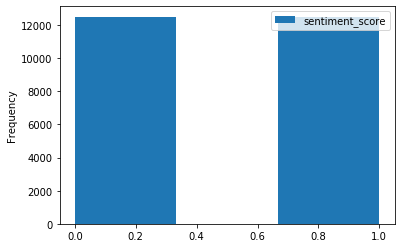

In [0]:
train_df.plot.hist('sentiment_score', bins=3)

In [0]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


## Model

We are now ready with our dataset. And ready to build model to train on this data.

In [0]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


Build model...


In [0]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


## Model Training
Model is prepared. Below cell would initiate training. Ideally for this IMDB dataset and with our model architecture it takes around 12-15 epochs to converge. But to save time and just to demo - we are restricting the training here to 2 epochs. (which whould take around 5 mins to complete)

In [0]:
print('Train...')
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=2,
                    validation_data=(x_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 164s 7ms/step - loss: 0.4688 - acc: 0.7724 - val_loss: 0.4095 - val_acc: 0.8220
Epoch 2/2
25000/25000 [==============================] - 163s 7ms/step - loss: 0.2989 - acc: 0.8804 - val_loss: 0.3794 - val_acc: 0.8372


In [0]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 22s 895us/step
Test score: 0.37943297105789187
Test accuracy: 0.8372


We can see that in given epochs what is the trend of `accuracy` and `loss`.

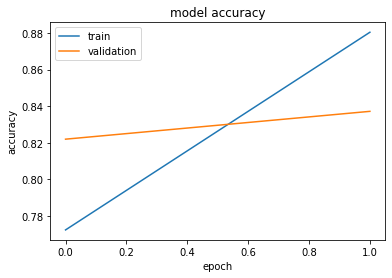

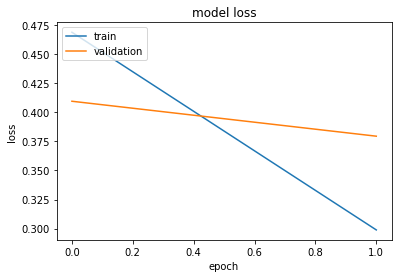

In [0]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Confusion Metrix
We just have two labels here so our confusion metrix is relatively smaller.

Please note that we have just trained 2 epochs (for demo) so this model is not really to it's full potential - so there can be high confusion. But here is how we can understand model's confusion.

In [0]:
import numpy as np
import sklearn.metrics as metrics

y_pred = model.predict(x_test)
y_pred_labels = np.where(y_pred >= 0.5, 1, 0).flatten()

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)

In [0]:
confusion_matrix

array([[10334,  2166],
       [ 1904, 10596]])

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=4):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

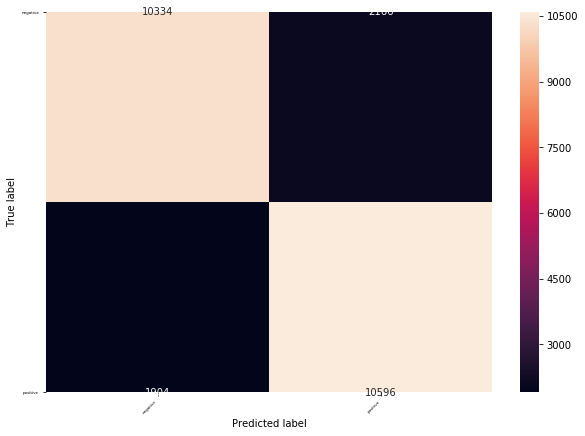

In [0]:
print_confusion_matrix(confusion_matrix, ["negative", "positive"])

# Prediction

We can test on a new review for testing model

In [0]:
def predict(text):
  text_input=[word_to_id[word] if word in word_to_id else word_to_id["<UNK>"] for word in text.split(" ")]
  padded_input = sequence.pad_sequences([text_input], maxlen=maxlen)
  pred=model.predict(padded_input)
  pred=np.where(pred >= 0.5, "positive", "negative").flatten()
  prediction = pred[0]
  return prediction

# New Section

In [0]:
text="that movie is trash ."

In [0]:
print("For Text: {}".format(text))
print("Prediction by model is: {}".format(predict(text)))

For Text: that movie is trash . it has bad music and scrappy action sequence . waste of money
Prediction by model is: negative
